                                                                   Helga Sigríður Thordersen Magnúsdóttir s202027 
                                                                                 Hlynur Árni Sigurjónsson s192302
                                                                             Katrín Erla Bergsveinsdóttir s202026
                                                                                Kristín Björk Lilliendahl s192296
 
 ![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

<img src="https://susfans.eu/sites/default/files/clients/DTU.png"  align="right" width="300"/>

# Advanced Business Analytics - Project

## Tripadvisor - Copenhagen restaurants reviews

<br>

The idea is to scrape Tripadvisor reviews of restaurants in Copenhagen.

We all know the struggle of when we are going out to eat and no one knows where to go.. 

<br>

<img src="https://media.giphy.com/media/GDqDZOPSZJC00/giphy.gif" width="500" align="center">

<br>

We wanted to analyse restaurants in the capital of Denmark, Copenhagen. Especially, because we are foreign students from Iceland, and therefore we often have to look at Tripadvisor to find out where to eat. Moreover, we thought it would be an interested dataset to analyse from a business perspective. That will be discussed later on in [Chapter 4 Business questions](#businessquestions).

We wanted to gain information about review text, rating and time of review. Furthermore, we also wanted to get the restaurants information and basic reviewer information. 

#### The information gained would be

* Review text, rating and time of review.
* The resturant's information.
* Basic reviewer information.

#### Our thoughts of what can be done with the data

* Create a network of reviewers and restaurants
* Sentiment analysis on the reviews
* Word embedding on the reviews
* Words associated with bad and good reviews
* Recommendation system based on ratings
* Time laps of reviews based on location
* Spacial prediction and trends
* Fraud detection (detecting un-authentic reviews)
* Are there any neighborhoods better rated than others


## Contents
* [1 Scraper info](#scraper)
* [2 The datasets and data preparation](#datasets)
    * [2.1 restaurantInfo.csv](#restaurantInfo)
    * [2.2 reviews.csv](#reviews)
    * [2.3 reviewerInfo.csv](#reviewer)
    * [2.4 Shapefiles](#shapefiles)
* [3 Descriptive stats](#descStats)
    * [3.1 Restaurants](#restaurants)
    * [3.2 Reviews](#reviews)
* [4 Business questions](#businessquestions)

<hr>

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## Imported data 🐼 
The first step as always is to install and import the necessary packages.

In [ ]:
# !pip install pandas_profiling
# !pip install folium
# !pip install -U selenium

# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import ast
import matplotlib.pyplot as plt
%matplotlib inline 
from pandas_profiling import ProfileReport
import requests
import urllib.parse
import folium
import geopandas as gpd
import json
from datetime import datetime

#  Scraper packages
import requests 
from bs4 import BeautifulSoup
import csv 
from selenium import webdriver
import time
import sys
import os
import argparse
import string
import pickle

 ![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

<a id='scraper'></a>
# 1. Scraper info 

🆘 <font color='red'>It is not necessary to run the scraper code. It was added for reference to what was done in the scraper.</font> 🆘 \
A scraper tool is created to gather the reviews and the restaurants information into csv files. The skeleton of the tool was taken from a github page [LaskasP](https://github.com/LaskasP/TripAdvisor-Python-Scraper-Restaurants-2021). It later turned out that the code had many errors and crashed after a few calls. So the scraper tool was fixed and improved, with enriching the information gathered. In addition, information about reviewers was created. Since the data was large and the tool was expected to encounter some errors on the way, the urls links are stored into a csv. In our case, we chose to look into resturant in the Copenhagen area, with over 1900 resturants available. Each restaurant has on average 700 reviews so the scraping time is quick to add up.

The scraper is based on the **beautifulsoup** package and **selenium**. The reason for using selenium is to open and click on things, to retrieve next pages or additional information.

#### Selenium actions:
* Click the "next" button since Tripadvisor only displays 20 restaurants or reviews at each page
* Click the "boxes" that pop out with additional information about reviewers
* Click on the "more" button when a review is exceeding a certain length

#### Procedure:
* Find a Tripadvisor page with the selected area and select only restaurants
* Run the **scrapeRestaurantsUrlsAll** function, this function retrieves all the urls in the selected area
* Run through all the urls and scrape the reviews with the **get_reviews function**
* If successful retrieval of all reviews, then remove the resturant urls csv file
* Sperately run the **scrapeRestaurantInfo** function to get the information of the restaurants

As can be seen in the three code snippets below there are a lot of "try: except:" clauses in the code. This is due to many smaller deviation on the Tripadvisor webpage. Data can be missing for some restaurants so the scraper tries to retrieve them, if not successful, it is left empty.

#### Scrape all restaurants urls

With the help of **selenium** the "next page" button is pushed until it has reached the end. Every resturant's url that is not "sponsored" in the ordering is saved. The sponsored restaurant appear many times and often the same restaurants, if this would be skipped, that data would have a lot of duplicates. Moreover, what is worse, is that it would extend the scraper tools to be a big margin.

In [ ]:
# Get urls for all "next" pages in a selected area
def scrapeRestaurantsUrlsAll(url, limit=100):
    store_name = []
    urls = []
    limit_set = 1
    nextPage = True
    while nextPage and limit_set <= limit:
        page = requests.get(url)
        soup = BeautifulSoup(page.text, 'html.parser')
        results = soup.find('div', class_='_1kXteagE')
        stores = results.find_all('div', class_='wQjYiB7z') 
        for store in stores:
            if store.find('a', class_ = '_15_ydu6b').text[0].isdigit(): # skip the ones that er sponsored since they will also come later.
                
                print(store.find('a', class_ = '_15_ydu6b').text)
                unModifiedUrl = str(store.find('a', href=True)['href'])
                urls.append('https://www.tripadvisor.com'+unModifiedUrl)
        limit_set += 1
        #Go to next page if exists
        try:
            print('tried next in finding all')
            unModifiedUrl = str(soup.find('a', class_ = 'nav next rndBtn ui_button primary taLnk',href=True)['href'])
            # print(unModifiedUrl, 'later unmod')
            url = 'https://www.tripadvisor.com' + unModifiedUrl
            # print('new url is ', url)
        except:
            print('no next in finding all')
            nextPage = False

    with open(pathAllRestaurants, 'wb') as f:
        pickle.dump(urls, f)

    print(f'Total restaurant count: {len(urls)}')
    return urls

#### Scrape the restaurants information 

The restaurants information is scraped. Here the most applicable data was retrieved and stored into a seperate csv file. Here the **beautifulsoup** package was sufficient to retreive the data needed. Again, here we see many "try: except:" clauses in the code since there is some missing information for many of the resturants.

In [ ]:
def scrapeRestaurantInfo(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    storeName = soup.find('h1', class_='_3a1XQ88S').text
    try:
        avgRating = soup.find('span', class_='r2Cf69qf').text.strip()
        nrReviews = soup.find('a', class_='_10Iv7dOs').text.strip().split()[0]
    except:
        avgRating = None
        nrReviews = 0
    storeAddress = soup.find('div', class_= '_2vbD36Hr _36TL14Jn').find('span', class_='_2saB_OSe').text.strip()
#     urlAddress = str(soup.find('div', class_ = '_2vbD36Hr _36TL14Jn').find('span').find('a', href=True)['href'])
    
    try:
        cousineType = [word.text for  word in soup.find('span', class_='_13OzAOXO _34GKdBMV').find_all('a')]
        cousine = True
    except:
        cousineType = []
        cousine = False
    nrPos = soup.find('a', class_='_15QfMZ2L').find('b').find('span').text.strip()
    
    # Other rankings 
    all_ranks = []
    try:
        all_ranks = [word.text for word in soup.find('div', class_ = '_3acGlZjD').find_all('div', class_ = '_3-W4EexF')]
    except:
        all_ranks = []
        
    # Other ratings
    all_ratings = []
    try:
        rating = soup.find_all('div', class_='jT_QMHn2')
        rating_type = [x.find('span', class_ = '_2vS3p6SS').text for x in rating]
        true_rating = [x.find('span', class_ = '_377onWB-') for x in rating]
        true_rating = [int(str(x.findChildren('span')).split('_')[3][:2])/10 for x in true_rating]
        all_ratings = list(zip(rating_type,true_rating))
    except:
        all_ratings = []
        
    with open(restaurantInfo, mode='a', encoding="utf-8") as trip:
        data_writer = csv.writer(trip, delimiter = ',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)
        if len(cousineType) > 1:
            data_writer.writerow([storeName, storeAddress, avgRating, nrReviews, cousineType[0], cousineType[1:], nrPos, all_ranks, all_ratings])
        elif len(cousineType) == 1:
            data_writer.writerow([storeName, storeAddress, avgRating, nrReviews, cousineType[0], [], nrPos, all_ranks, all_ratings])
        else:
            data_writer.writerow([storeName, storeAddress, avgRating, nrReviews, [], [], nrPos, all_ranks, all_ratings])

#### Get the reviewers information

Here **selenium** came to the rescue, as the need to click buttons on the reviewers own page was neccessary. The information stored here is mainly in the hope to get the connection between reviewers and restaurants. Tripadvisor has a community of reviewers and they can follow each other as on social platforms. The information in that regard is gathered along with the total reviews and "upvotes" the reviewer gives. The hope here is to shed light on the influence of specific reviewers and the value it could add to restaurants. Here detecting bad or fraudulent reviews is hopefully possible with the data at hand. The most frequent available data is the location and the join date of the reviewer. This information is quite important since a network can be created based on those attributes.

In [ ]:
# Get all the reviwer info, location, join date, review count, upvotes, followers and following.
def reviewerInfo(url):
    username = url
    full_url = f"https://www.tripadvisor.com/Profile/{url}"
    driver.get(full_url)
    time.sleep(1)

    # Get Intro info, location and join date
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    try:
        location = soup.find('span', class_ = "_2VknwlEe _3J15flPT default").text
    except:
        location = None

    try:
        joined = soup.find('span', class_ = "_1CdMKu4t").text
    except:
        joined = None


    all_links = soup.find_all('div', class_ = '_1aVEDY08')
    # link = driver.find_elements_by_xpath("//div[@class='nkw-3XeH']/div[1]/span[2]/a")

    # # Get the contributions info
    nrContributions = int(str(all_links[0].text).split()[1])
    if nrContributions > 0:
        link = driver.find_elements_by_xpath("//div[@class='nkw-3XeH']/div[1]/span[2]/a")
        driver.execute_script("arguments[0].click();", link[0])
        time.sleep(1)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        nrReviews = int(str(soup.find('span', class_ = 'ui_icon pencil-paper _1LSVmZLi').parent.text).split()[0])
        try:
            nrUpvotes = int(str(soup.find('span', class_ ='ui_icon thumbs-up _1LSVmZLi _3zmXi7gU').parent.text).split()[0])
        except:
            nrUpvotes = 0
        close = driver.find_elements_by_xpath("//div[@class='_2EFRp_bb _9Wi4Mpeb']")
        driver.execute_script("arguments[0].click();", close[0])
    else:
        nrReviews = 0
        nrUpvotes = 0

    # Get Followers
    nrFollowers = int(str(all_links[1].text).split()[1])
    if nrFollowers > 0:
        link = driver.find_elements_by_xpath("//div[@class='nkw-3XeH']/div[2]/span[2]/a")
        driver.execute_script("arguments[0].click();", link[0])
        time.sleep(1)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        followers = [word.text for word in soup.find('div', class_='_1caczhWN').find_all('span', class_='gf69u3Nd')]
        close = driver.find_elements_by_xpath("//div[@class='_2EFRp_bb _9Wi4Mpeb']")
        driver.execute_script("arguments[0].click();", close[0])
    else:
        followers = []

    # Get all following
    nrFollowing = int(str(all_links[2].text).split()[1])
    if nrFollowing > 0:
        link = driver.find_elements_by_xpath("//div[@class='nkw-3XeH']/div[3]/span[2]/a")
        driver.execute_script("arguments[0].click();", link[0])
        time.sleep(1)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        following = [word.text for word in soup.find('div', class_='_1caczhWN').find_all('span', class_='gf69u3Nd')]
        close = driver.find_elements_by_xpath("//div[@class='_2EFRp_bb _9Wi4Mpeb']")
        driver.execute_script("arguments[0].click();", close[0])
    else:
        following = []

    with open(pathtoReviewers, mode='a', encoding="utf-8") as reviewer_data:
        data_writer = csv.writer(reviewer_data, delimiter = ',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)
        data_writer.writerow([username, location, joined, nrContributions,nrReviews, nrUpvotes, nrFollowers, followers, nrFollowing,following])

#### Initialise files and get the data

The data is gathered by firstly getting all urls, then looping through them and scraping the information. Firstly, initilise the file and the relevant column names.

In [ ]:
pathToReviews = "reviews.csv"
restaurantInfo = "restaurantInfo.csv"
pathAllRestaurants = "AllRestaurants.txt"

with open(restaurantInfo, mode='a', encoding="utf-8") as trip:
    data_writer = csv.writer(trip, delimiter = ',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)
    data_writer.writerow(['storeName', 'storeAddress', 'avgRating', 'nrReviews', 'priceCategory','CousineType', 'Rank'])
#webDriver init

with open(pathToReviews, mode='a', encoding="utf-8") as trip_data:
    data_writer = csv.writer(trip_data, delimiter = ',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)
    data_writer.writerow(['storeName', 'reviewerUsername', 'ratingDate', 'reviewHeader','reviewText', 'rating'])

#### Getting the reviews
Scrape all of the reviews and keep track of what urls are finished and who are left.

In [ ]:
with open("urls_left.txt", "rb") as f:   # Unpickling
    urls_left = pickle.load(f)

# initialize the selenium driver    
driver_path = f'../scraper/{os.getcwd()}/chromedriver'
driver = webdriver.Chrome(driver_path)
urls_left = urls.copy()

# Do this in steps of 100 restaurants since the code takes multiple hours to run
finished = []
bad_url = []
next_100 = urls_left[0:100]
for url in next_100:
    try:
        get_reviews(url)
        finished.append(url)
    except:
        bad_url.append(url)

Remove the urls that are successful. Take a look at those that failed and try to fix what was missing or caused the bad retrieval.

In [ ]:
finished_urls = [urls_left[x].index for x in finished]

for idx in finished_urls:
    del urls_left[idx]

#### Getting restaurant information 

Here we run a function that gets the website with a request, the html parser is then used from **beautifulsoup** and the needed tags are located and stored.

In [ ]:
with open("AllRestaurants.txt", "rb") as f:   # Unpickling
    urls = pickle.load(f)

bad_url = []
for url in urls:
    try:
        scrapeRestaurantInfo(url)
    except:
        bad_url.append(url)

Here, bad_url contained restaurant with no reviews and thus deemed reduntant to our dataset.

#### Getting reviwer information 
Scraping the reviews information after the file has been created from the dataframe

In [ ]:
driver_path = f'{os.getcwd()}/chromedriver'
driver = webdriver.Chrome(driver_path)

with open("reviewers.txt", "r") as f:
    reviewers = f.readlines()

for reviewer in reviewers:
    reviewerInfo(reviewer)

#### Merging csv files

In order to gather the data in a shorter time, multiple environments were run in paralell to gather the data simultaneously. 

In [ ]:
import csv
reader = csv.reader(open("Data/reviews1.csv"))
reader1 = csv.reader(open("Data/reviews2.csv"))
reader2 = csv.reader(open("Data/reviews22.csv"))

# Skip the first lines when combining
next(reader1)
next(reader2)

f = open("Data/reviews.csv", "w")
writer = csv.writer(f)

for row in reader:
    writer.writerow(row)
for row in reader1:
    writer.writerow(row)
for row in reader2:
    writer.writerow(row)
f.close()

 ![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

<a id="datasets"></a>
# 2. The datasets and data preparation

As mentioned in the scraper section the tool used to go iteratively through every "next" page of a specific Tripadvisor restaurant's review and gather the wanted information. The restaurants information is also scraped seperately. 

The data is saved into two files:
1. **restaurantInfo.csv**: Contains information about each resturant.
2. **reviews.csv**: Contains the reviews for each restaurant.

We start by importing the raw data files, cleaning and preparing them for further analysis.

Additionally, another dataset was downloaded from the internet. It included shapefiles of Denmark with municipality division.

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

<a id="restaurantInfo"></a>
## 2.1 restaurantInfo.csv

As mentioned before, **restaurantInfo.csv** contains information about each restaurant. The informations are as follows:

* **storeName**: That is the information about the name of the restaurant
* **storeAddress**: Contains the restaurant address
* **avgRating**: Is the average rating per restaurant
* **nrReviews**: Information about how many reviews each restaurant has
* **priceCategory**: Information about the price range of this restaurant
* **CousineType**: List of cousine types the restaurant offers 
* **all_ranks**: List of where the restaurants ranks
* **all_ratings**: List of all available ratings, e.g. service, food ect. 

From the informations above 👆🏼 we can see that we have three columns that contain a list, **CousineType**, **all_ranks** and **all_ratings**. 
If we would read the csv file without doing anything, the columns would appear as strings. So in order to prevent that and import it as a list we need to use **converters** to read it in correctly.

Let's examine how the data looks by loading the **restaurantInfo.csv** into a pandas dataframe.


In [ ]:
restaurants = pd.read_csv('Data/restaurantInfo.csv', converters={'CousineType':ast.literal_eval, 'all_ranks': ast.literal_eval, 'all_ratings': ast.literal_eval})
restaurants.head()

,storeName,storeAddress,avgRating,nrReviews,priceCategory,CousineType,all_ranks,all_ratings
0,Maple Casual Dining,"Vesterbrogade 24, Copenhagen 1620 Denmark",5.0,237,$$ - $$$,"[International, European, Vegetarian Friendly]","[#1 of 95 International in Copenhagen, #1 of 1...","[(Food, 5.0), (Service, 5.0), (Value, 4.5)]"
1,Keyser Social,"Frederiksborggade 20d, Copenhagen 1360 Denmark",5.0,125,$$$$,"[Asian, Thai, Vegetarian Friendly]","[#2 of 1,971 Restaurants in Copenhagen]","[(Food, 5.0), (Service, 5.0), (Value, 5.0)]"
2,Restaurant Krebsegaarden,"Studiestraede 17, Copenhagen 1455 Denmark",5.0,"1,403",$$$$,"[European, Scandinavian, Danish]","[#2 of 840 European in Copenhagen, #3 of 1,971...","[(Food, 5.0), (Service, 5.0), (Value, 4.5), (A..."
3,The Olive Kitchen & Bar,"Noerregade 22, Copenhagen 1165 Denmark",5.0,"2,413",$$ - $$$,"[International, European, Gluten Free Options]","[#4 of 1,971 Restaurants in Copenhagen]","[(Food, 5.0), (Service, 5.0), (Value, 4.5)]"
4,Ark,"Noerre Farimagsgade 63, Copenhagen 1364 Denmark",5.0,277,$$ - $$$,"[European, Contemporary, Healthy]","[#5 of 840 European in Copenhagen, #5 of 1,971...","[(Food, 4.5), (Service, 5.0), (Value, 4.5)]"


By examining the dataframe we can see that the **priceCategory** column appears to be displaying in a weird way or not showing all the data. 

Let's take a look if it does not import correctly to the dataframe or the view can not display it correctly 🤔

In [ ]:
restaurants.iloc[0]

storeName                                      Maple Casual Dining
storeAddress             Vesterbrogade 24, Copenhagen 1620 Denmark
avgRating                                                        5
nrReviews                                                      237
priceCategory                                             $$ - $$$
CousineType         [International, European, Vegetarian Friendly]
all_ranks        [#1 of 95 International in Copenhagen, #1 of 1...
all_ratings            [(Food, 5.0), (Service, 5.0), (Value, 4.5)]
Name: 0, dtype: object

By looking at the first row we can see that Maple Casual Dining has a correct information in the **priceCategory** so the information imported correctly into the dataframe ✅

### Data Cleaning 🧹 

In order to work further with the dataset, we need to clean the dataframe. 
Since we now know that the **priceCategory** is imported correctly, we can start cleaning the column. Since '$$' is a keyword in Matplotlib, the column has to be mapped to something. A mapping to integers was created, since they are a nice way to represent the data. 

In [ ]:
# Since the Pandas profiler can no display string with '$$' it is necessary to map the price categories differently
restaurants.priceCategory = restaurants.priceCategory.map({'$': 1, '$ - $$': 1.5, '$$': 2, '$$ - $$$': 2.5, '$$$': 3, '$$$ - $$$$': 3.5, '$$$$': 4, '$$$$ - $$$$$': 4.5, '$$$$$': 5})

## Additional Dataset 🗺

Since we were able to obtain the address for each restaurant it would be nice to be able to plot the restaurants, to see the locations and use it for further analysis. In order to do so, we need to get the latitude and longitude coordinates of the restaurant address. 

This can be achieved by using the address as a query string and calling the Open Street maps. Since some of the addresses are in a weird format, the name of the restaurant will first be used in the search query (with 'denmark' added at the end to clarify the search). If the location information can be found from the restaurant name, that will be used. If the location information can not be found from the name then the address will be used to generate the latitude and longitude.

In [ ]:
# Iterate through all the rows of the dataset and gather the lat and lon info into vectors
# First we use the lat/lon info found from the restaurant name since that could be considered more accurate 
# since users have to label the restaurant on a map. Otherwise the info from the address is used.
# Finally we collect the display name, to be able to extract the municipality information

# Create vectors to store information
lats = []
lons = []
displayNames = []

for idx, row in restaurants.iterrows():
    
    lat = None
    lon = None
    displayName = None
    address = row.storeAddress
    name = row.storeName
    url1 = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(name + " denmark") +'?format=json'
    url2 = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'

    # Make the first request based on the name
    response1 = requests.get(url1).json()
    
    if response1:
        lat = response1[0]["lat"]
        lon = response1[0]["lon"]
        displayName = response1[0]["display_name"]
    else:
        # make the second request based on the address
        response2 = requests.get(url2).json()
        if response2:
            lat = response2[0]["lat"]
            lon = response2[0]["lon"]
            displayName = response2[0]["display_name"]
    
    # Append the info we gathered into the vectors
    lats.append(lat)
    lons.append(lon)
    displayNames.append(displayName)
    
# Add the vectors to the dataset
restaurants['lat'] = lats
restaurants['lon'] = lons
restaurants['location'] = displayNames

💡 Now there should be two new columns in the dataframe presenting the latitute and longitude for each restaurant.

In [ ]:
restaurants.iloc[0]

storeName                                      Maple Casual Dining
storeAddress             Vesterbrogade 24, Copenhagen 1620 Denmark
avgRating                                                        5
nrReviews                                                      237
priceCategory                                                  2.5
CousineType         [International, European, Vegetarian Friendly]
all_ranks        [#1 of 95 International in Copenhagen, #1 of 1...
all_ratings            [(Food, 5.0), (Service, 5.0), (Value, 4.5)]
lat                                                     55.6729579
lon                                                     12.5581383
location         Maple Casual Dining, Vesterbrogade, Kødbyen, V...
Name: 0, dtype: object

Correct!
We can see that 'Maple Casual Dining' is located in Vesterbrogade 24, coordinates (55.67, 12.558) 🌍

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

<a id="reviews"></a>
## 2.2 reviews.csv

Next up is looking into **reviews.csv** . It containts information about each review for every restaurant. Namely:
* **soreName**: That is the information about the name of the restaurant
* **reviewerUsername**: The username of the reviewer
* **ratingDate**: The date the rating is created
* **reviewHeader**: The header of the review
* **reviewText**: The review that the customer wrote
* **rating**: The rating the user gave, the range is from 1-5 ⭐️

Let's import the reviews to a new dataframe:


In [ ]:
reviews = pd.read_csv('Data/reviews.csv')
reviews.head()

,storeName,reviewerUsername,ratingDate,reviewHeader,reviewText,rating
0,Maple Casual Dining,918emmaf,"December 5, 2020",Exquisite,We visited Maple in Friday night and had a won...,5
1,Maple Casual Dining,hildurj2016,"November 19, 2020",Perfect wedding dinner,"Excellent food, drinks and service!! Me and my...",5
2,Maple Casual Dining,Judy B,"October 27, 2020",Beautifully Presented Food,I visited this restaurant on my first ever vis...,5
3,Maple Casual Dining,EldBjoern,"October 18, 2020",Very good food and very pleasant people,We ate dinner in their restaurant. The waiter ...,5
4,Maple Casual Dining,MacondoExpresss,"October 13, 2020",A lovely birthday dinner,Visited as a couple to celebrate my birthday. ...,5


The dataframe looks good, however we need to make sure that **ratingDate** is presented in a correct way, that is as a date:  

In [ ]:
print(reviews.iloc[0].ratingDate)
print(type(reviews.iloc[0].ratingDate))

December 5, 2020
<class 'str'>


We can see that **ratingDate** is a string. 
For further analysis, it will be benefitial to have converted this column into a timestamp object and that is done by using datetime:

In [ ]:
reviews['ratingDate'] = reviews['ratingDate'].apply(lambda x: datetime.strptime(x, '%B %d, %Y'))
print(reviews.iloc[0].ratingDate)
print(type(reviews.iloc[0].ratingDate))

2020-12-05 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


Great!
**ratingDate** is now in the correct format and we are able to work with the dataframe 💯

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

<a id="shapefiles"></a>
## 2.3 Shapefiles

Interesting thing to look into is the different areas the restaurants are located. 
One way of doing that is to use shapefile.

> The shapefile format is a digital vector storage format for storing geometric location and associated attribute information.

Shapefiles for the whole of Denmark were downloaded from [here](https://www.diva-gis.org/datadown).
The files include information about the municipalities and their division within Denmark.
These can be used later on when performing analysis that require information about different areas of Denmark.

The first step is to load and examine the dataset:

In [ ]:
shp = 'DNK_adm/DNK_adm2.shp'
gdf = gpd.read_file(shp)

gdf.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
0,64,DNK,Denmark,1,Hovedstaden,1,Albertslund,Kommune,Municipality,None,None,"POLYGON ((12.37129 55.66019, 12.36338 55.65877..."
1,64,DNK,Denmark,1,Hovedstaden,2,Allerød,Kommune,Municipality,None,None,"POLYGON ((12.20744 55.82782, 12.21004 55.83235..."
2,64,DNK,Denmark,1,Hovedstaden,3,Ballerup,Kommune,Municipality,None,None,"POLYGON ((12.42482 55.70868, 12.41010 55.70942..."
3,64,DNK,Denmark,1,Hovedstaden,4,Bornholm,Kommune,Municipality,None,None,"POLYGON ((14.88805 55.03042, 14.88805 55.03058..."
4,64,DNK,Denmark,1,Hovedstaden,5,Brøndby,Kommune,Municipality,None,None,"MULTIPOLYGON (((12.45293 55.66484, 12.45315 55..."


For simplification, all analysis performed will be focused on the capital region. Therefore, the shapefile is filtered on *Hovedstaden* and some of the included islands are skipped so the plot will be as clear as possible 🏝

Each municipality will be plotted in a different color based on their numerical ID in the shapefile.

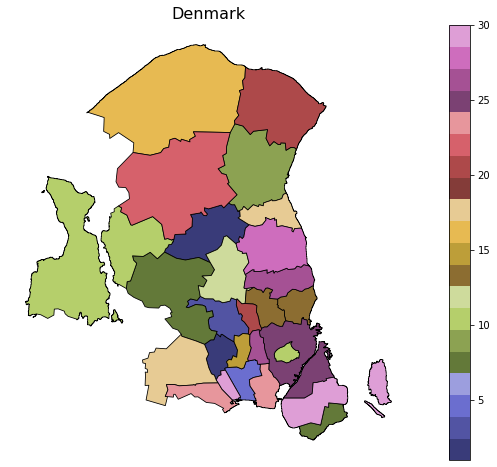

In [ ]:
# Filter on the areas we want displayed
hovedstaden = gdf[(gdf.ID_1==1) & (gdf.NAME_2 != 'Bornholm') & (gdf.NAME_2 != 'Christiansø') & (gdf.NAME_2 != 'Halsnæs')]

# Plot the shapefiles
fig, ax = plt.subplots(1, figsize=(14, 8));
hovedstaden.plot(column='ID_2', cmap='tab20b', linewidth=0.8, ax=ax, edgecolor='black', legend=True);
ax.axis('off');
ax.set_title('Denmark', fontsize=16);

 ![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

<a id="descStats"></a>
# 3. Descriptive Statistics 

Now we have scraped and imported all the necessary data we need, therefore we can check if we have any outliers, statistically numerical values of different columns in our dataset, and so on. This will be done by using Pandas **ProfileReport**. 

> Pandas profiling saves the work of visualizing and understanding the distribution of each variable. It generates a report with all the information easily available. 👌

Let's begin to look at the Restaurants dataframe!



<a id="restaurants"></a>
## 3.1. Restaurants

We now put the cleaned dataframe from [Chapter 2.1 restaurantInfo.csv](#restaurantInfo) into the Pandas **ProfileReport** to generate a profile and displaying it:

In [ ]:
restaurant_profile = ProfileReport(restaurants, title="Restaurants Info dataset", html={'style': {'full_width': True}});
restaurant_profile.to_notebook_iframe();

Firstly, we can see that the columns storeName, storeAddress, nrReviews and location have high-cardinality, which refers to columns with values that are very uncommon or unique. However, that makes sense because we are analysing different restaurants. Moreover, it is interesting to see that several restaurants appear few times. These restaurants are for example places like Joe & The Juice, Sticks'n'Sushi and McDonald's, which are franchises all over Denmark. We can see that these are not duplicates, as seen in the code below:

In [ ]:
restaurants.loc[(restaurants['storeName'] == 'Joe & The Juice')&(restaurants['storeName']=='Joe & the Juice')] 


Secondly, by looking at the avgRate column, we can see that the minimum value is 1 and maximum value is 5, which tells us that there are no strange values in that column. Moreover, we see that the average value for ratings is around 3.97. Therefore, customers that are satisfied are maybe more likely to give a review - or maybe Copenhagen just have great restaurants! 🥳 Could be interesting to look more into later on.

In the column storeAddress, we see that there are 6 restaurants with the same address, which is Vesterbrogade 3, Copenhagen 1630 Denmark. We wanted to look further into it:

In [ ]:
restaurants.loc[(restaurants['storeAddress'] == 'Vesterbrogade 24, Copenhagen 1620 Denmark')]

By Google-ing the address we can see that these restaurants above are located in a food hall, and therefore it makes sense that they have the same address! 🏠

We see that the column priceCategory has 579 or 24.7% missing values. However, it won't make a huge difference for our analyses later on. It will not be the main variable we will look at.

From the profiler it can be seen that it does not handle a column containing a list. Therefore, we do an additional check for the **CousineType** column. The reference code can be found [here](https://stackoverflow.com/questions/49017002/bar-plot-based-on-list-of-string-values).

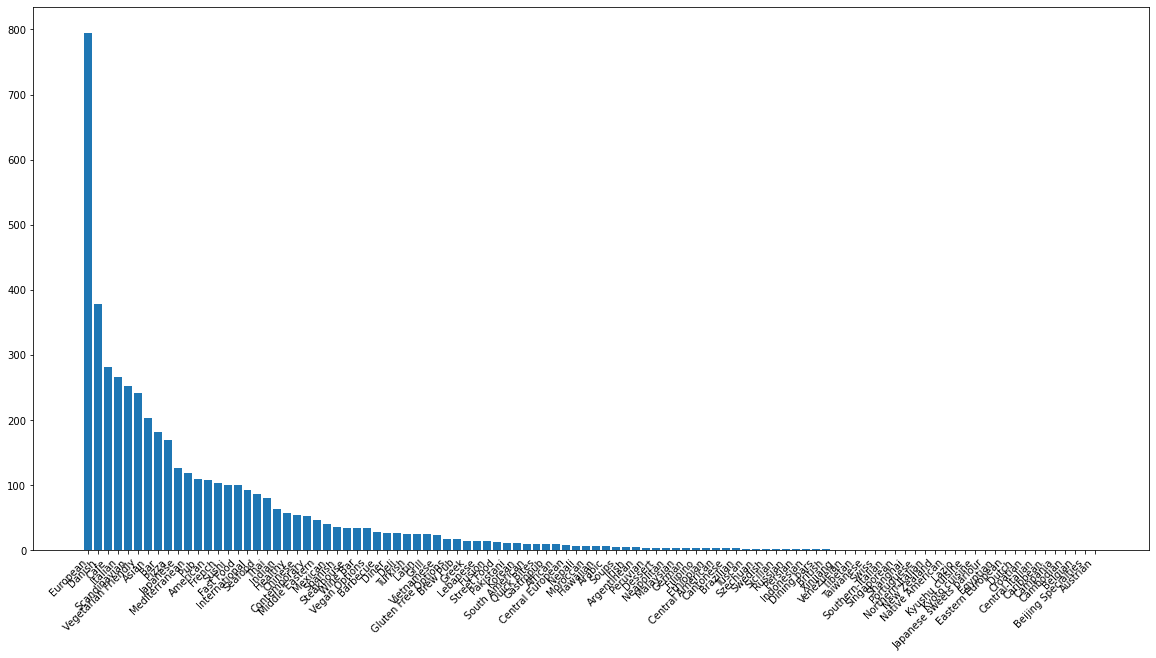

In [ ]:
CousineTypeFlat = [y for x in restaurants.CousineType for y in x]

keys, counts = np.unique(CousineTypeFlat, return_counts=True)

counts, keys = zip(*sorted(zip(counts, keys), reverse=True))

plt.figure(figsize=(20,10))
plt.bar(keys, counts)
plt.xticks(rotation=45, ha='right')
plt.show()

From the plot above we can see that most restaurants offer European dishes 🇪🇺, followed by Danish cousine 🇩🇰. Austrian dishes are the hardest one to find in restaurants in Copenhagen 🇦🇹. 

When looking at the profile for latitude and longitude, we clearly see that we have some weird outliers in our dataframe. The average coordinates of Copenhagen are 55.6761 N latitude and 12.5683 E longitude. However, by looking at the minumum number in the latitude column we have -35.008636 and for the longitude column the minumum number is -87.83865855. Moreover, the maximum value is also weird for the longitude column, it is 121.0348037. 

 Let's plot the latitude and longitude of our dataframe to find the outlier/s.

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(restaurants['lat'], bins = 50, color = "skyblue")
plt.hist(restaurants['lon'], bins = 50, color = "salmon")
plt.show()

Let's also find what restaurant has the minimum value in latitude:

In [ ]:
restaurants.loc[(restaurants['lat'] == -35.008636)]

In [ ]:
restaurants.loc[(restaurants['lon'] == -87.83865855)&(resturant.['lon'] == 121.0348037)]]

**skrifa um**

In [ ]:
restaurants['lat'].between(-35.008636, 50, inclusive=False)

We want to see where the restaurants are located in Copenhagen. Therefore, we plotted them below. However, the plot only shows the top 350 restaurants in Copenhagen because the map code could not handle more data. When running with more than 350 it would not display. The reference code can be found [here](https://georgetsilva.github.io/posts/mapping-points-with-folium/).

In [ ]:
locations = restaurants[['lat', 'lon']]
locations = locations.dropna()
locationlist = locations.values.tolist()

map = folium.Map(location=[55.7, 12.6], zoom_start=12)
for point in range(0, 350): #len(locationlist)
     folium.Marker(locationlist[point], popup=restaurants['storeName'][point]).add_to(map)
map

By looking at the top 350 restaurants in our dataframe, we can see that we have several outliers. One of the restaurant is located in London, England. Moreover, numerous restaurants are located outside of Copenhagen, but we were only focusing on the Copenhagen Area 😒. However, we are not going to anything now for these outliers but we might do it later on when working on our business questions. 

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

<a id="reviews"></a>
## 3.2 Reviews


Let's now do the same here for the Reviews dataframe, as we did for the Restaurant dataframe. That is, apply Pandas **ProfileReport** on it.

In [ ]:
# Generate a profile for the dataset and display it
reviews_profile = ProfileReport(reviews, title="Reviews dataset", html={'style': {'full_width': True}});
reviews_profile.to_notebook_iframe();

Firstly, we see that the restaurant Kodbyens Fiskebar, is the restaurant which is most often reviewed. Let's look at where this restaurant is ranked in Copenhagen.

In [ ]:
restaurants.loc[restaurants['storeName'] == 'Kodbyens Fiskebar']

We can see that Kodbyens Fiskebar is ranked number 12 of 82 Seafood restaurants in Copenhagen and number 160 overall for restaurants in Copenhagen. These numerous reviews for this restaurant are clearly good! 😌 

Secondly, we see that the column reviewerUsername has a high cardinality or 37870 distinct values. This tells us that we have 37870 different users, rating restaurants. This column is also well distributed as we can see that the most frequent reviewer only has 0.1% of all the reviews. 

Finally, by looking at the ratingDate column, the number of reviews are increasing year by year. Most likely due to more technology like smartphones and better internet, and people are also travelling more frequently. Interestingly, there are fewer reviews for the year 2020, which is obviously due to Covid. Let's plot it:

In [ ]:
plt.figure(figsize=(8,5))

plt.hist(reviews['ratingDate'], bins = 50, color = "purple")

<a id="miscellaneous"></a>
## 3.3 Miscellaneous 

It was decided to pickle all the dataframes, mainly because it takes a long time to run the latitude and longitude code. It was also done to save time by not having to run all the code again. Now we have the cleaned and prepared dataframes ready for our business questions 😁. The reference code can be found [here](https://stackoverflow.com/questions/17098654/how-to-store-a-dataframe-using-pandas).

In [ ]:
restaurants.to_pickle('Data/restaurants.pkl')  # where to save it, usually as a .pkl
reviews.to_pickle('Data/reviews.pkl')
gdf.to_pickle('Data/gdf.pkl')

 ![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

<a id='businessquestions'></a>
# 4. Business Questions


The business questions ideas for the project are the following:

1. Can we predict up and coming neigborhoods based on restaurant rating or newly opened restaurants ?
2. Does the advertised cousine type of the restaurant represent what the reviewers really like ?
3. Showing the trend of restaurant and how the movement based on rating and restaurant availability has changed over time 
4. Provide insight into what makes a good and bad review, what are the keywoards and can we filter out to get a report for the restaurant improvement points? 
5. Network analysis based on the connection between reviewers or restaurants
6. Where should you place your restaurant in the city based on the surrounding restaurant types and causines. Is there space for a new pizza place or are they simply to many ? Are there only low rated pizza places in the neighbourhood where your ambition will thrive ? 
7. Recommendation system based on similar reviewer's interest or similar restaurant characteristics
8. Create a machine learning model to predict a review rating based on the review text.

The group is going to choose some of these ideas. However, they might change as the project goes along. 

Hlynur/Kristín (1, 2, 3, 6)

Helga/Katrín (4, 8):

**Business Question**: Based on text analytics of reviews. For example, the most common word, what words are associated with good reviews and for bad reviews. Moreover, create a machine learning model to predict a review rating based on the review text.